# Data Load

In [13]:
import torch 
import numpy as np 
import sklearn as sk 
import pandas as pd 
import seaborn as sns 
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

# TO Tensor + Normalize + Flatten 
transform = transforms.Compose([transforms.ToTensor() ,
                                transforms.Normalize(mean=0 , std=1) , 
                                transforms.Lambda(lambda x: x.view(-1))])

import torch.nn.functional as F  
def collate_fn(batch):
    images, labels = zip(*batch)  
    images = torch.stack(images)  
    labels = torch.tensor(labels)  
    one_hot_labels = F.one_hot(labels, num_classes=10).float() 
    return images, one_hot_labels

Train_set = torchvision.datasets.FashionMNIST(root='./data' , train=True , download=True , transform=transform)
Test_set = torchvision.datasets.FashionMNIST(root='./data' , train=False , download=True , transform=transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(Train_set, batch_size=32, shuffle=True , collate_fn=collate_fn)
test_loader = DataLoader(Test_set, batch_size = 32 , shuffle=True , collate_fn=collate_fn)


data_iter = iter(test_loader)
images, labels = data_iter.__next__()
print("Transformed batch of images shape (flattened):", images.shape) 
print("One-hot encoded labels shape:", labels.shape)
print("One-hot encoded label:" , labels[0])

data_iter = iter(train_loader)
images, labels = data_iter.__next__()
print("Transformed batch of images shape (flattened):", images.shape) 
print("One-hot encoded labels shape:", labels.shape)


print("len of MLP input: "  , images.shape[1])
print("len of MLP output"  , labels.shape[1])

in_mlp =  images.shape[1]
out_mlp = labels.shape[1]

Transformed batch of images shape (flattened): torch.Size([32, 784])
One-hot encoded labels shape: torch.Size([32, 10])
One-hot encoded label: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Transformed batch of images shape (flattened): torch.Size([32, 784])
One-hot encoded labels shape: torch.Size([32, 10])
len of MLP input:  784
len of MLP output 10


In [14]:
def train_loop(model , num_epochs , optimizer , loss_fnc):  
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:

            optimizer.zero_grad() 

            outputs = model(inputs.to(device))

            loss = loss_fnc(outputs.cpu(), labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            pred = torch.argmax(outputs.cpu(), dim=1)
            act = torch.argmax(labels, dim=1)
            correct_train += ( pred == act).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train


        model.eval() 
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(device))
                loss = loss_fnc(outputs.cpu(), labels)
            
                val_loss += loss.item()

                pred = torch.argmax(outputs.cpu(), dim=1)
                act = torch.argmax(labels, dim=1)

                correct_val += (pred == act).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_acc = correct_val / total_val
                    

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses , val_losses , train_accuracies , val_accuracies

# Defining one Model for all optimization methods

In [15]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

device = 'cpu' # apparently from previous question, Runs faster than MPS

In [17]:
# Model 

class MLP(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size_1=196 , hidden_size_2 = 98 ,
                 hidden_size_3 = 49, output_size=out_mlp):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)   
        self.normal_1 = nn.BatchNorm1d(196)            
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        #self.fc3 = nn.Linear(hidden_size_2 , hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_2 , output_size)
        self.normal_2 = nn.BatchNorm1d(98)
        self.normal_3 = nn.BatchNorm1d(49) 

        self.drop_1 = nn.Dropout(0.15)
        self.drop_2 = nn.Dropout(0.15)
        self.drop_3 = nn.Dropout(0.15)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.normal_1(x)
        x = self.drop_1(x)

        x = F.relu(self.fc2(x))

        x = self.fc4(x) 
        x = self.flatten(x)
        return x

model_1 = MLP() # using Adam
model_1.to(device=device)
loss_fnc_1 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001 , weight_decay=0.0001)

summary(model_1 , images)



Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 196]                 153,860
├─BatchNorm1d: 1-2                       [-1, 196]                 392
├─Dropout: 1-3                           [-1, 196]                 --
├─Linear: 1-4                            [-1, 98]                  19,306
├─Linear: 1-5                            [-1, 10]                  990
├─Flatten: 1-6                           [-1, 10]                  --
Total params: 174,548
Trainable params: 174,548
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.67
Estimated Total Size (MB): 0.77


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 196]                 153,860
├─BatchNorm1d: 1-2                       [-1, 196]                 392
├─Dropout: 1-3                           [-1, 196]                 --
├─Linear: 1-4                            [-1, 98]                  19,306
├─Linear: 1-5                            [-1, 10]                  990
├─Flatten: 1-6                           [-1, 10]                  --
Total params: 174,548
Trainable params: 174,548
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.67
Estimated Total Size (MB): 0.77

In [18]:
info = train_loop(model_1 , 20 , optimizer_1 , loss_fnc_1)

Epoch [1/20], Train Loss: 0.4962, Val Loss: 0.4145, Train Acc: 0.8209, Val Acc: 0.8540
Epoch [2/20], Train Loss: 0.4100, Val Loss: 0.4017, Train Acc: 0.8507, Val Acc: 0.8549
Epoch [3/20], Train Loss: 0.3857, Val Loss: 0.3963, Train Acc: 0.8585, Val Acc: 0.8515
Epoch [4/20], Train Loss: 0.3699, Val Loss: 0.3948, Train Acc: 0.8630, Val Acc: 0.8615
Epoch [5/20], Train Loss: 0.3579, Val Loss: 0.3562, Train Acc: 0.8680, Val Acc: 0.8728
Epoch [6/20], Train Loss: 0.3468, Val Loss: 0.3563, Train Acc: 0.8718, Val Acc: 0.8700
Epoch [7/20], Train Loss: 0.3394, Val Loss: 0.3559, Train Acc: 0.8743, Val Acc: 0.8726
Epoch [8/20], Train Loss: 0.3391, Val Loss: 0.3802, Train Acc: 0.8761, Val Acc: 0.8667
Epoch [9/20], Train Loss: 0.3330, Val Loss: 0.3561, Train Acc: 0.8768, Val Acc: 0.8717
Epoch [10/20], Train Loss: 0.3251, Val Loss: 0.3716, Train Acc: 0.8793, Val Acc: 0.8700
Epoch [11/20], Train Loss: 0.3242, Val Loss: 0.3430, Train Acc: 0.8803, Val Acc: 0.8750
Epoch [12/20], Train Loss: 0.3223, Val Lo

In [19]:
model_2 = MLP() # using NAdam
model_2.to(device=device)
loss_fnc_2 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_2 = optim.NAdam(model_2.parameters(), lr=0.001 , weight_decay=0.0001)

info_2 = train_loop(model_2 , 20 , optimizer_2 , loss_fnc_2)

Epoch [1/20], Train Loss: 0.4934, Val Loss: 0.4843, Train Acc: 0.8252, Val Acc: 0.8191
Epoch [2/20], Train Loss: 0.4067, Val Loss: 0.4265, Train Acc: 0.8523, Val Acc: 0.8565
Epoch [3/20], Train Loss: 0.3824, Val Loss: 0.3808, Train Acc: 0.8603, Val Acc: 0.8642
Epoch [4/20], Train Loss: 0.3763, Val Loss: 0.3979, Train Acc: 0.8637, Val Acc: 0.8556
Epoch [5/20], Train Loss: 0.3586, Val Loss: 0.3701, Train Acc: 0.8681, Val Acc: 0.8651
Epoch [6/20], Train Loss: 0.3468, Val Loss: 0.3554, Train Acc: 0.8728, Val Acc: 0.8723
Epoch [7/20], Train Loss: 0.3376, Val Loss: 0.3661, Train Acc: 0.8761, Val Acc: 0.8658
Epoch [8/20], Train Loss: 0.3336, Val Loss: 0.3646, Train Acc: 0.8770, Val Acc: 0.8699
Epoch [9/20], Train Loss: 0.3293, Val Loss: 0.3715, Train Acc: 0.8787, Val Acc: 0.8655
Epoch [10/20], Train Loss: 0.3258, Val Loss: 0.3520, Train Acc: 0.8786, Val Acc: 0.8735
Epoch [11/20], Train Loss: 0.3215, Val Loss: 0.3566, Train Acc: 0.8811, Val Acc: 0.8734
Epoch [12/20], Train Loss: 0.3153, Val Lo

In [20]:
model_3 = MLP() # using RMSprop
model_3.to(device=device)
loss_fnc_3 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_3 = optim.RMSprop(model_3.parameters(), lr=0.001 , weight_decay=0.0001)

info_3 = train_loop(model_3 , 20 , optimizer_3 , loss_fnc_3)

Epoch [1/20], Train Loss: 0.4891, Val Loss: 0.4503, Train Acc: 0.8236, Val Acc: 0.8370
Epoch [2/20], Train Loss: 0.4092, Val Loss: 0.4293, Train Acc: 0.8519, Val Acc: 0.8445
Epoch [3/20], Train Loss: 0.3853, Val Loss: 0.3805, Train Acc: 0.8592, Val Acc: 0.8612
Epoch [4/20], Train Loss: 0.3711, Val Loss: 0.3946, Train Acc: 0.8651, Val Acc: 0.8620
Epoch [5/20], Train Loss: 0.3600, Val Loss: 0.3918, Train Acc: 0.8679, Val Acc: 0.8628
Epoch [6/20], Train Loss: 0.3464, Val Loss: 0.3878, Train Acc: 0.8728, Val Acc: 0.8580
Epoch [7/20], Train Loss: 0.3372, Val Loss: 0.3631, Train Acc: 0.8745, Val Acc: 0.8715
Epoch [8/20], Train Loss: 0.3347, Val Loss: 0.3592, Train Acc: 0.8782, Val Acc: 0.8733
Epoch [9/20], Train Loss: 0.3327, Val Loss: 0.3588, Train Acc: 0.8773, Val Acc: 0.8725
Epoch [10/20], Train Loss: 0.3240, Val Loss: 0.3484, Train Acc: 0.8798, Val Acc: 0.8752
Epoch [11/20], Train Loss: 0.3204, Val Loss: 0.3852, Train Acc: 0.8807, Val Acc: 0.8708
Epoch [12/20], Train Loss: 0.3150, Val Lo

In [21]:
model_4 = MLP() # using SGD with momentum
model_4.to(device=device)
loss_fnc_4 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.001 , weight_decay=0.0001 , momentum=0.01)

info_4 = train_loop(model_4 , 20 , optimizer_4 , loss_fnc_4)

Epoch [1/20], Train Loss: 1.3046, Val Loss: 0.8198, Train Acc: 0.6575, Val Acc: 0.7590
Epoch [2/20], Train Loss: 0.7154, Val Loss: 0.6089, Train Acc: 0.7786, Val Acc: 0.7985
Epoch [3/20], Train Loss: 0.5782, Val Loss: 0.5276, Train Acc: 0.8075, Val Acc: 0.8198
Epoch [4/20], Train Loss: 0.5157, Val Loss: 0.4850, Train Acc: 0.8239, Val Acc: 0.8304
Epoch [5/20], Train Loss: 0.4771, Val Loss: 0.4591, Train Acc: 0.8349, Val Acc: 0.8377
Epoch [6/20], Train Loss: 0.4517, Val Loss: 0.4422, Train Acc: 0.8430, Val Acc: 0.8449
Epoch [7/20], Train Loss: 0.4334, Val Loss: 0.4238, Train Acc: 0.8491, Val Acc: 0.8482
Epoch [8/20], Train Loss: 0.4167, Val Loss: 0.4128, Train Acc: 0.8542, Val Acc: 0.8544
Epoch [9/20], Train Loss: 0.4032, Val Loss: 0.4062, Train Acc: 0.8577, Val Acc: 0.8547
Epoch [10/20], Train Loss: 0.3899, Val Loss: 0.3944, Train Acc: 0.8628, Val Acc: 0.8583
Epoch [11/20], Train Loss: 0.3821, Val Loss: 0.3878, Train Acc: 0.8638, Val Acc: 0.8600
Epoch [12/20], Train Loss: 0.3715, Val Lo

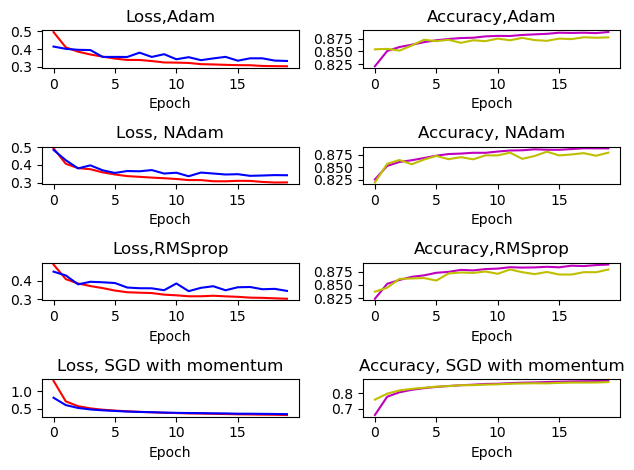

In [24]:

figure , ax = plt.subplots(4, 2)

ax[0,0].set_xlabel("Epoch")
ax[0 , 0].set_title("Loss,Adam")
ax[0 , 0].plot(info[0] , color = 'r' , label = "Train")
ax[0, 0].plot(info[1] , color = 'b' , label = "Test")

ax[0,1].set_xlabel("Epoch")
ax[0 , 1].set_title("Accuracy,Adam")
ax[0 , 1].plot(info[2] , color = 'm' , label = "Train")
ax[0 , 1].plot(info[3], color = 'y' , label = "Test")

ax[1,0].set_xlabel("Epoch")
ax[1 , 0].set_title("Loss, NAdam")
ax[1 , 0].plot(info_2[0] , color = 'r' , label = "Train")
ax[1, 0].plot(info_2[1] , color = 'b' , label = "Test")

ax[1,1].set_xlabel("Epoch")
ax[1 , 1].set_title("Accuracy, NAdam")
ax[1 , 1].plot(info_2[2] , color = 'm' , label = "Train")
ax[1 , 1].plot(info_2[3], color = 'y' , label = "Test")


ax[2,0].set_xlabel("Epoch")
ax[2 , 0].set_title("Loss,RMSprop")
ax[2 , 0].plot(info_3[0] , color = 'r' , label = "Train")
ax[2, 0].plot(info_3[1] , color = 'b' , label = "Test")

ax[2,1].set_xlabel("Epoch")
ax[2 , 1].set_title("Accuracy,RMSprop")
ax[2 , 1].plot(info_3[2] , color = 'm' , label = "Train")
ax[2 , 1].plot(info_3[3], color = 'y' , label = "Test")

ax[3,0].set_xlabel("Epoch")
ax[3 , 0].set_title("Loss, SGD with momentum")
ax[3 , 0].plot(info_4[0] , color = 'r' , label = "Train")
ax[3, 0].plot(info_4[1] , color = 'b' , label = "Test")

ax[3,1].set_xlabel("Epoch")
ax[3 , 1].set_title("Accuracy, SGD with momentum")
ax[3 , 1].plot(info_4[2] , color = 'm' , label = "Train")
ax[3 , 1].plot(info_4[3], color = 'y' , label = "Test")


plt.tight_layout()

In [31]:
# metrics 
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score, jaccard_score
def metrics(model):
    train_labels = np.zeros(shape=[1 , 10])
    train_predictions = np.zeros(shape=[1 , 10])
    test_labels = np.zeros(shape=[1 , 10])
    test_prediction = np.zeros(shape=[1 , 10])
    with torch.no_grad(): 
            for inputs, labels in train_loader:
                outputs_train = model(inputs.to(device))
                train_labels = np.append(train_labels , labels.numpy() , axis=0)
                train_predictions =np.append(train_predictions , outputs_train.numpy() ,axis=0)
            for inputs, labels in test_loader:
                outputs_test = model(inputs.to(device))
                test_labels = np.append(test_labels  , labels.numpy(), axis=0)
                test_prediction = np.append(test_prediction ,outputs_test.numpy() ,axis=0)
    train_labels  = train_labels[1: , :]
    train_predictions = train_predictions[1: , :]
    test_labels   = test_labels [1: , :]
    test_prediction = test_prediction[1: , :]

    accuracy_t = accuracy_score(np.argmax(train_labels ,axis=-1) ,np.argmax(train_predictions,axis=-1))
    precision_t = precision_score(np.argmax(train_labels ,axis=-1) ,np.argmax(train_predictions,axis=-1) ,average='macro')
    recall_t = recall_score(np.argmax(train_labels ,axis=-1) ,np.argmax(train_predictions,axis=-1) , average='macro')
    f1_score_t = f1_score(np.argmax(train_labels ,axis=-1) ,np.argmax(train_predictions,axis=-1) , average='macro')
    j_score_t = jaccard_score(np.argmax(train_labels ,axis=-1) ,np.argmax(train_predictions,axis=-1) , average='macro')


    accuracy_v = accuracy_score(np.argmax(test_labels ,axis=-1) , np.argmax(test_prediction ,axis=-1))
    precision_v = precision_score(np.argmax(test_labels ,axis=-1) , np.argmax(test_prediction ,axis=-1) , average='macro')
    recall_v = recall_score(np.argmax(test_labels ,axis=-1) , np.argmax(test_prediction ,axis=-1), average='macro' )
    f1_score_v = f1_score(np.argmax(test_labels ,axis=-1) , np.argmax(test_prediction ,axis=-1), average='macro' )
    j_score_v = jaccard_score(np.argmax(test_labels ,axis=-1) , np.argmax(test_prediction ,axis=-1), average='macro' )

    return accuracy_t, precision_t , recall_t , f1_score_t , j_score_t , accuracy_v, precision_v, recall_v , f1_score_v , j_score_v

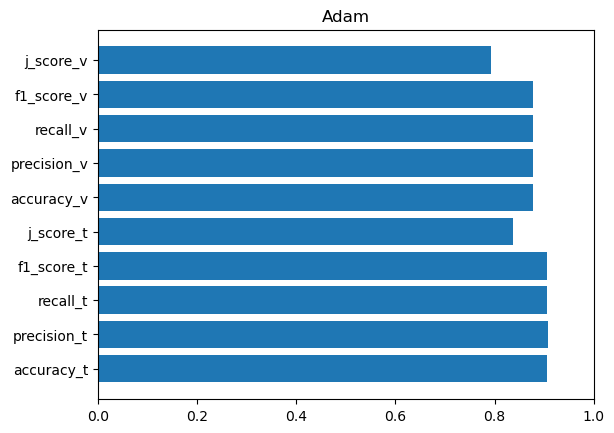

In [39]:
m1 = metrics(model_1)
x_bar = ['accuracy_t', 'precision_t' , 'recall_t' , 'f1_score_t' , 'j_score_t' , 'accuracy_v', 'precision_v', 'recall_v' , 'f1_score_v' , 'j_score_v']
plt.barh(x_bar , m1 )
plt.title("Adam")
plt.xlim(0 , 1.000)
plt.show()

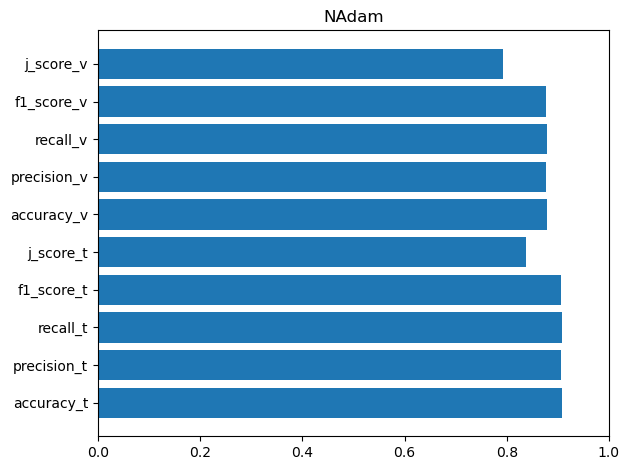

In [40]:
m2= metrics(model_2)
x_bar = ['accuracy_t', 'precision_t' , 'recall_t' , 'f1_score_t' , 'j_score_t' , 'accuracy_v', 'precision_v', 'recall_v' , 'f1_score_v' , 'j_score_v']
plt.barh(x_bar , m2 )
plt.title("NAdam")
plt.xlim(0 , 1.000)
plt.tight_layout()
plt.show()

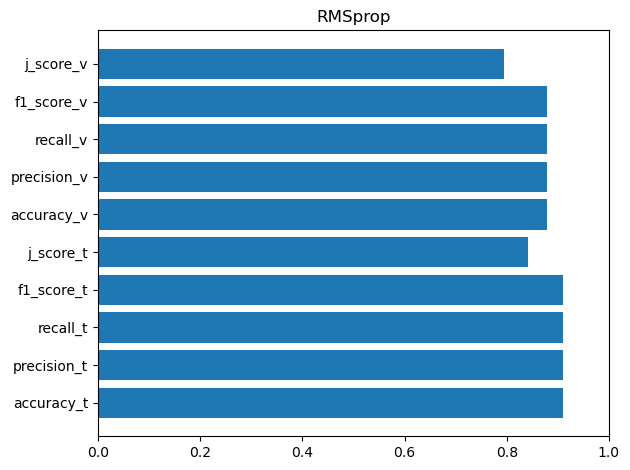

In [41]:
m3= metrics(model_3)
x_bar = ['accuracy_t', 'precision_t' , 'recall_t' , 'f1_score_t' , 'j_score_t' , 'accuracy_v', 'precision_v', 'recall_v' , 'f1_score_v' , 'j_score_v']
plt.barh(x_bar , m3 )
plt.title("RMSprop")
plt.xlim(0 , 1.000)
plt.tight_layout()
plt.show()

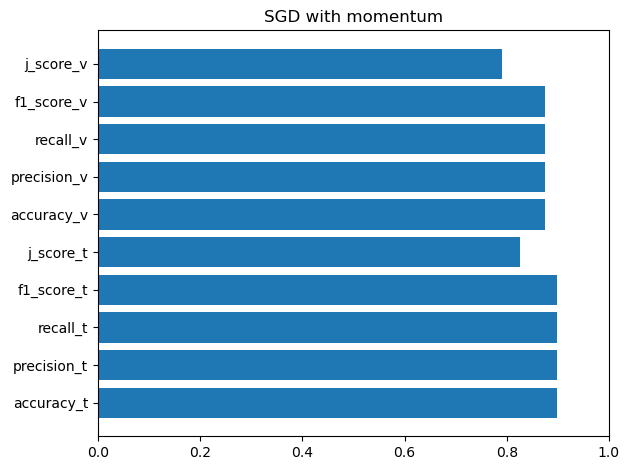

In [43]:
m4= metrics(model_4)
x_bar = ['accuracy_t', 'precision_t' , 'recall_t' , 'f1_score_t' , 'j_score_t' , 'accuracy_v', 'precision_v', 'recall_v' , 'f1_score_v' , 'j_score_v']
plt.barh(x_bar , m4 )
plt.title("SGD with momentum")
plt.xlim(0 , 1.000)
plt.tight_layout()
plt.show()

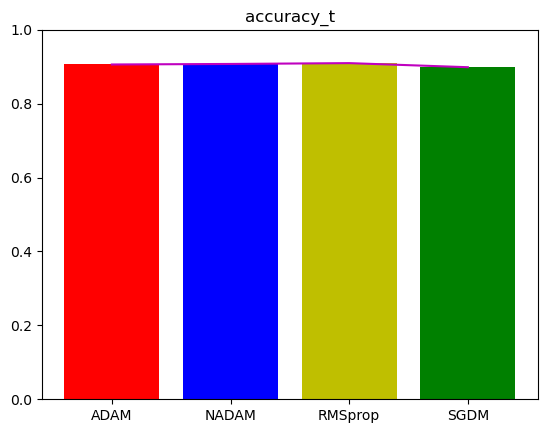

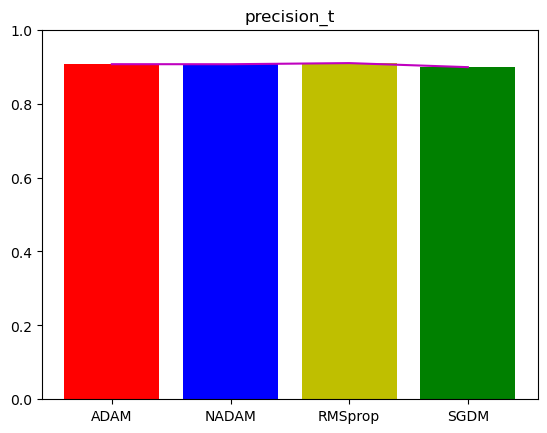

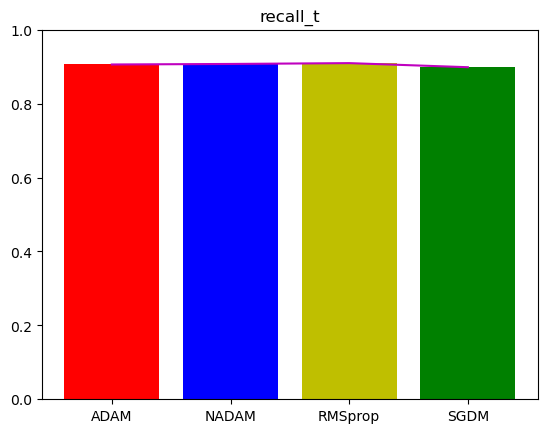

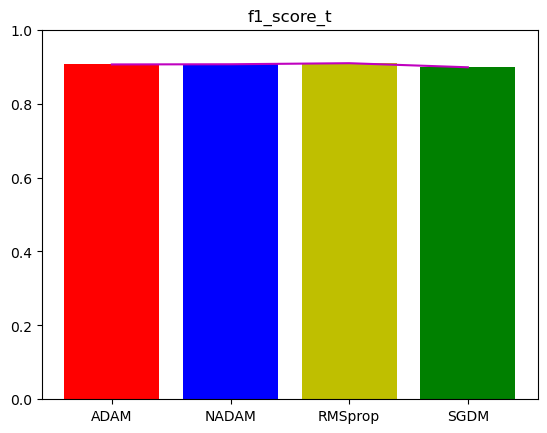

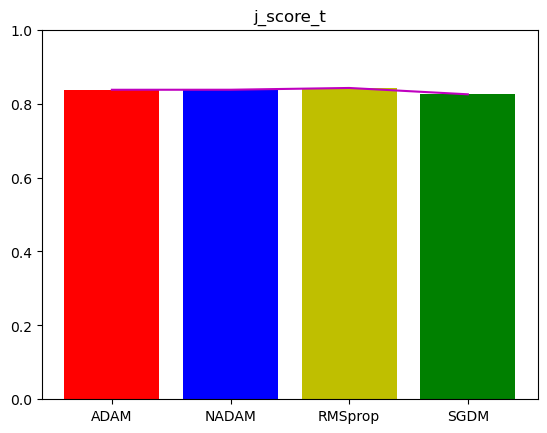

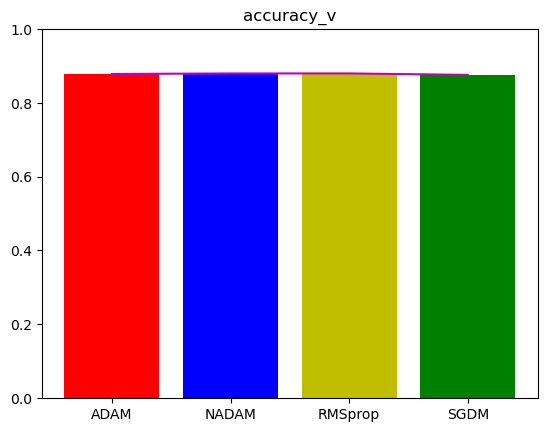

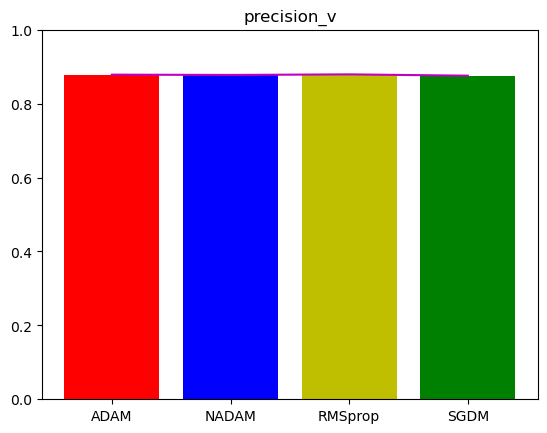

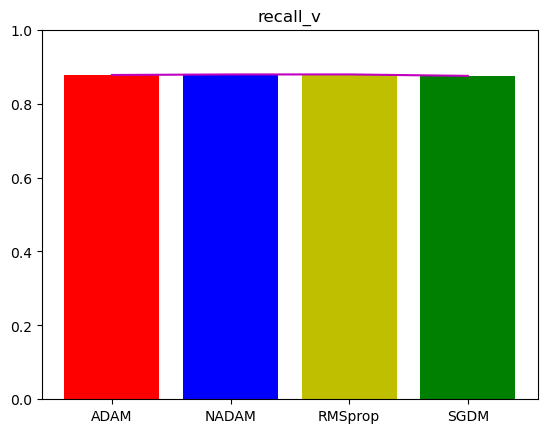

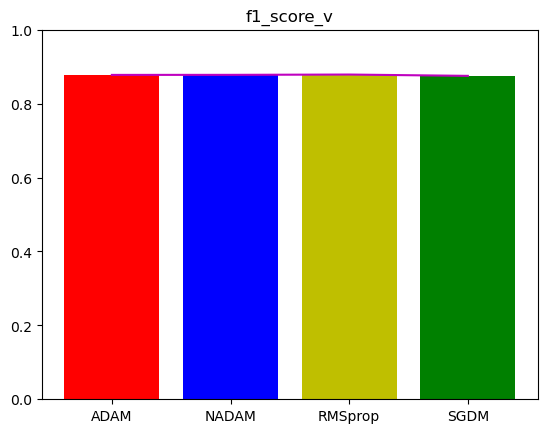

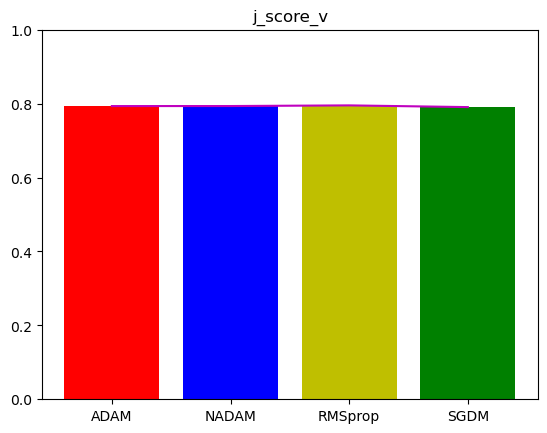

In [55]:
y_bar = ["ADAM" , "NADAM" ,"RMSprop" , "SGDM" ]
for i in range(0 , 10):
    plt.bar(y_bar , [m1[i] , m2[i] , m3[i], m4[i]] , color = ['r' , 'b' , 'y' , 'g'])
    plt.plot(y_bar , [m1[i] , m2[i] , m3[i], m4[i]] , color = 'm')
    plt.title(x_bar[i])
    plt.ylim(0, 1.000)
    plt.show()
    

## A light Model for Bayesian Search vs Grid Search 

In [64]:
# Model 

class MLP(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size_1=32 , drop_rate = 0.15, output_size=out_mlp):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)            
        self.fc2 = nn.Linear(hidden_size_1, out_mlp)
        self.drop_1 = nn.Dropout(drop_rate)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_1(x)
        x = self.fc2(x) 
        x = self.flatten(x)
        return x


loss_fnc = nn.CrossEntropyLoss() 

In [73]:
# Hyperparameter space
hidden_sizes = np.arange(32 , 64 , step = 10)
dropout_rates = [0.1, 0.15, 0.25]
learning_rates = [0.0001 , 0.001 , 0.01]

In [74]:
hidden_sizes_u = hidden_sizes[0]
dropout_rates_u = dropout_rates[0]
learning_rates_u = learning_rates[0]
old_accuracy = 0

In [75]:
def train_loop(model , num_epochs , optimizer , loss_fnc):  
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:

            optimizer.zero_grad() 

            outputs = model(inputs.to(device))

            loss = loss_fnc(outputs.cpu(), labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            pred = torch.argmax(outputs.cpu(), dim=1)
            act = torch.argmax(labels, dim=1)
            correct_train += ( pred == act).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train


        model.eval() 
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(device))
                loss = loss_fnc(outputs.cpu(), labels)
            
                val_loss += loss.item()

                pred = torch.argmax(outputs.cpu(), dim=1)
                act = torch.argmax(labels, dim=1)

                correct_val += (pred == act).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_acc = correct_val / total_val
                    

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
            
        #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses , val_losses , train_accuracies , val_accuracies

## Grid Search 

In [76]:
for i in hidden_sizes:
    for j in dropout_rates:
        for k in learning_rates:
            model_1 = MLP(hidden_size_1=i , drop_rate=j)
            optimizer = optim.Adam(params=model_1.parameters() , lr = k)
            info = train_loop(model_1 , 5 , optimizer , loss_fnc)
            print(info)
            accuracy_t = np.max(info[3])
            if(accuracy_t >= old_accuracy):
                hidden_sizes_u = i
                dropout_rates_u = j
                learning_rates_u = k
                old_accuracy = accuracy_t

([1.0404037439505258, 0.645177140490214, 0.5688301941315334, 0.5239704515536626, 0.49943647624651594], [0.6829932004498979, 0.5738766929878595, 0.5291285381530421, 0.5076796922344751, 0.4836239154917744], [0.6703333333333333, 0.7792333333333333, 0.8053833333333333, 0.8207333333333333, 0.8271333333333334], [0.7699, 0.8045, 0.818, 0.8241, 0.8309])
([0.6462496960878372, 0.45813135854403175, 0.4220561045447985, 0.40387685207128526, 0.38837244643966357], [0.47154129684542695, 0.4384072574849327, 0.41096521487917764, 0.39610508872202027, 0.3934185090489662], [0.7755833333333333, 0.8373, 0.8476833333333333, 0.85385, 0.8594166666666667], [0.8288, 0.8462, 0.854, 0.8561, 0.8567])
([0.6124279654741287, 0.5310419116457303, 0.5127761394619942, 0.5043886595646541, 0.49268395517865815], [0.49766647453887014, 0.5184659030014714, 0.548311666844371, 0.47172463709077894, 0.5281981224783312], [0.7766666666666666, 0.8082, 0.8148833333333333, 0.8162833333333334, 0.82295], [0.8159, 0.8256, 0.799, 0.8356, 0.8

In [80]:
print("best setting for the network is :")
print("number of hidden neurons:" , hidden_sizes_u)
print("dropout rate:" , dropout_rates_u)
print("learning rate:" , learning_rates_u)
print("Validation best accuracy" , old_accuracy)

best setting for the network is :
number of hidden neurons: 62
dropout rate: 0.1
learning rate: 0.001
Validation best accuracy 0.8699


#### Took 9 minutes 4 seconds to find the best setting for this small network (Timed using VS code on M2 pro)

##  Bayesian search

In [81]:
import optuna 

In [86]:
def objective(trial):
    # Hyperparameter search space
    hidden_size = trial.suggest_int('hidden_size', 32, 128)  # Range for hidden layer size
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.25)  # Range for dropout rate
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.01)  # Range for learning rate

    model_1 = MLP(hidden_size_1=hidden_size, drop_rate=dropout_rate)
    optimizer = optim.Adam(params=model_1.parameters(), lr=learning_rate)
    info = train_loop(model_1, 5, optimizer, loss_fnc)
    
    accuracy_t = np.max(info[3])


    return accuracy_t 

In [87]:
study = optuna.create_study(direction="maximize")

[I 2024-10-24 17:47:27,178] A new study created in memory with name: no-name-d563dfee-36a7-4ced-b00e-616a6d50add4


In [88]:
study.optimize(objective, n_trials=20)

/var/folders/f5/0zxl9sdd2pgfq6v24qf62qlm0000gn/T/ipykernel_96496/3659453614.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.01)  # Range for learning rate
[I 2024-10-24 17:47:50,713] Trial 0 finished with value: 0.8492 and parameters: {'hidden_size': 34, 'dropout_rate': 0.22493505485783463, 'learning_rate': 0.000526613309869291}. Best is trial 0 with value: 0.8492.
[I 2024-10-24 17:48:06,265] Trial 1 finished with value: 0.8635 and parameters: {'hidden_size': 100, 'dropout_rate': 0.21893362793489163, 'learning_rate': 0.0003256179819713562}. Best is trial 1 with value: 0.8635.
[I 2024-10-24 17:48:22,203] Trial 2 finished with value: 0.8624 and parameters: {'hidden_size': 70, 'dropout_rate': 0.22382401863099904, 'learning_rate': 0.0006020782186559975}. Best i

### Bayesian search took 5 min and 14.7 sec, over a larger continues space unlike the previous grid search (on M2 pro)

In [89]:
best_trial = study.best_trial
print("Best hyperparameters:")
print(f"Hidden size: {best_trial.params['hidden_size']}")
print(f"Dropout rate: {best_trial.params['dropout_rate']}")
print(f"Learning rate: {best_trial.params['learning_rate']}")

Best hyperparameters:
Hidden size: 120
Dropout rate: 0.1705651602942195
Learning rate: 0.001104953313066804
